In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import plotly.express as px
from scipy.optimize import minimize, brute, least_squares, leastsq, fsolve, curve_fit
import seaborn as sns

In [2]:
rates_data = pd.read_excel("https://github.com/vaishuchoppalli/interest-rate-model-and-fixed-income-product-pricing/blob/main/Historical_Rates.xlsx?raw=true", sheet_name=9)
rates_data.shape

(3248, 2)

In [3]:
# INPUTS
Starting_Date = '2022-08-01'
Num_Days = 50
dt = 1/252
model = 'CIR'
days_roll = 5 #no. of days rolling for moving average
skip = 5 #no. of days to skip, get data for every 'n' days
choice = 1 #select from 3 choices below
a=10
b=0.025
params = [a, b]

In [4]:
if choice == 1:
  # Selecting subset of dates
  rates = np.array(rates_data.loc[(rates_data['Date'] >= Starting_Date)].reset_index(drop=True).iloc[:Num_Days,1])/100
elif choice == 2:
  # Selecting subset of the data using moving average of rates
  rates_data['Close_ma'] = rates_data['Close'].rolling(days_roll).mean()
  rates = np.array(rates_data.loc[(rates_data['Date'] >= Starting_Date)].reset_index(drop=True).iloc[:Num_Days,2])/100
elif choice == 3:
  # Selecting data by skipping
  rates = np.array(rates_data.loc[(rates_data['Date'] >= Starting_Date)].reset_index(drop=True).iloc[:Num_Days:skip,1])/100
rates

array([0.02606, 0.02741, 0.02748, 0.02676, 0.0284 , 0.02765, 0.02797,
       0.02786, 0.02888, 0.02849, 0.02791, 0.02824, 0.02893, 0.0288 ,
       0.02989, 0.03037, 0.03054, 0.03106, 0.03026, 0.03035, 0.0311 ,
       0.0311 , 0.03133, 0.03265, 0.03193, 0.0334 , 0.03265, 0.03292,
       0.03321, 0.03362, 0.03422, 0.03412, 0.03459, 0.03448, 0.0349 ,
       0.03571, 0.0351 , 0.03708, 0.03697, 0.03878, 0.03964, 0.03705,
       0.03747, 0.03804, 0.03651, 0.03617, 0.03759, 0.03826, 0.03883,
       0.03888])

In [5]:
# Minimize method
def error_min(params, rates=rates, dt=dt, model=model):
    dr = rates[1:] - rates[:-1]
    drift = params[0] * (params[1] - rates) * dt
    if model == 'CIR':
        rw = (dr - drift[1:]) / np.sqrt(rates[1:])
        error = np.sum(rw ** 2)
    elif model == 'Vasicek':
        rw = (dr - drift[1:])
        error = np.sum(rw ** 2)
    return error*1000

# Least Squares method
def error_ls(params, rates=rates, dt=dt, model=model):
    dr = rates[1:] - rates[:-1]
    drift = params[0] * (params[1] - rates) * dt
    if model == 'CIR':
        rw = (dr - drift[1:]) / np.sqrt(rates[1:])
    elif model == 'Vasicek':
        rw = (dr - drift[1:])
    return rw

In [6]:
# Run solver using minimize method

result_min = minimize(error_min, params, rates, method = 'SLSQP')
print(result_min)

     fun: 1.0385445891970295
     jac: array([-0.0118362 , -0.00022194])
 message: 'Optimization terminated successfully'
    nfev: 297
     nit: 87
    njev: 87
  status: 0
 success: True
       x: array([0.02881608, 2.22574318])


In [7]:
# Run solver using least squares method
a=50
b=0.025
params = [a, b]
result_ls = least_squares(error_ls, params, bounds=([0, 0], [100, 0.15]), method='trf')
print(result_ls.x)

[0.53510754 0.15      ]


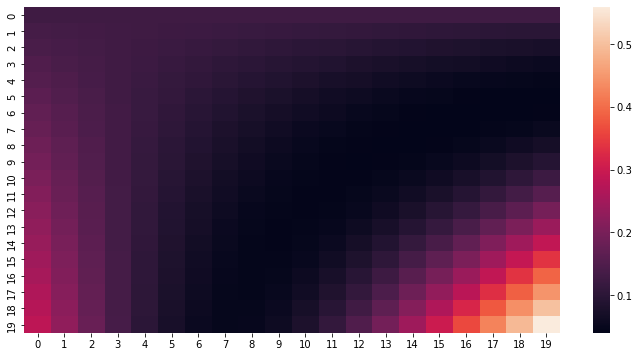

In [8]:
# Run solver using Brute force method

result_br = brute(error_min, ranges=((0,2),(0.01,0.15)), Ns=20, full_output=True, finish=None)
#print(result_br)

plt.figure(figsize=(12,6))
sns.heatmap(np.log(result_br[3]))
plt.show()

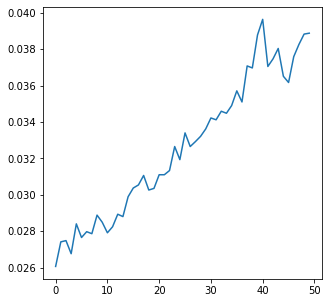

In [9]:
# Plotting rates
plt.figure(figsize=(5,5))
plt.plot(rates)

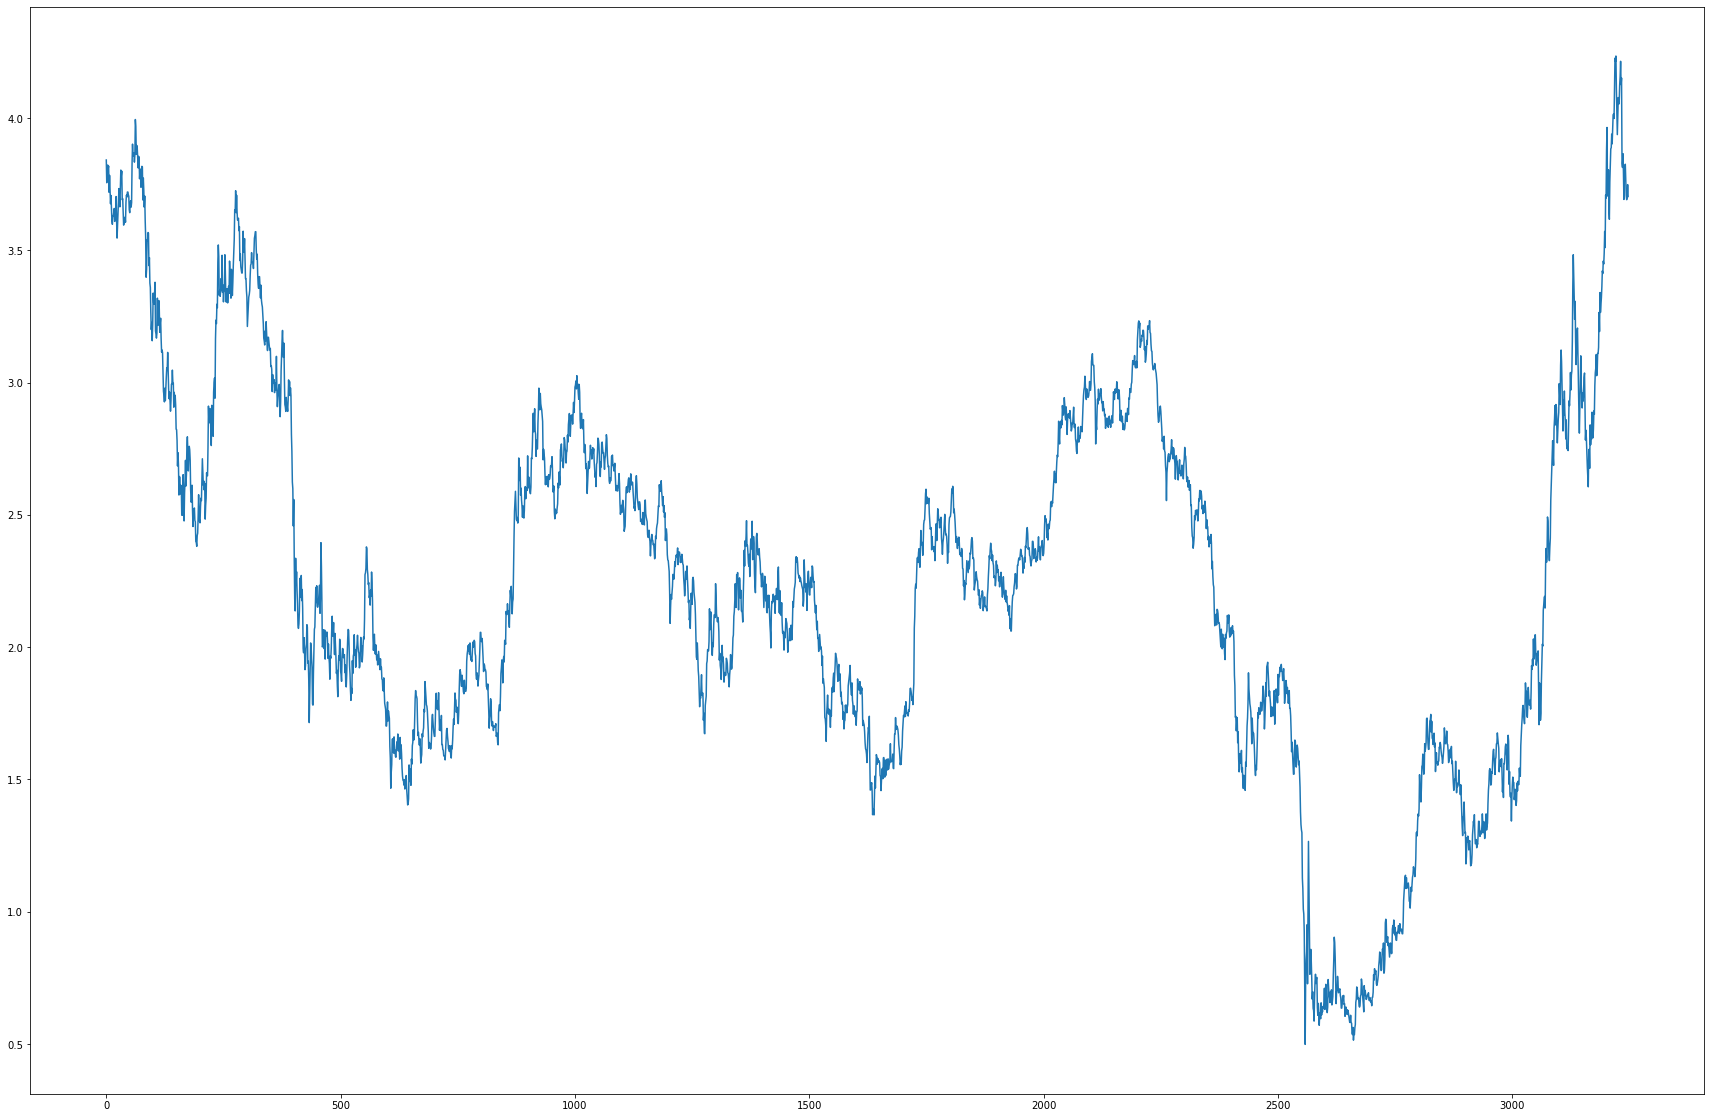

In [10]:
# Plotting Historical rates' close
plt.figure(figsize=(30,20))
plt.plot(rates_data['Close'])

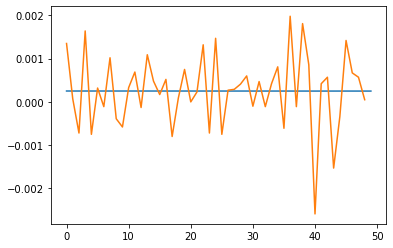

In [11]:
# Analysis
a_new, b_new = result_min.x
drift_new = a_new*(b_new-rates)*(dt)
dr=rates[1:]-rates[:-1]
plt.plot(drift_new)
plt.plot(dr)

In [12]:
# Generating sigma

def sigma(a_new, b_new, rates, dt=dt, model = model):
    dr = rates[1:] - rates[:-1]
    drift = a_new * (b_new - rates) * dt
    if model == 'CIR':
        rw = (dr - drift[1:]) / np.sqrt(rates[1:])
        sig = np.mean(rw ** 2) / dt
    elif model == 'Vasicek':
        rw = (dr - drift[1:])
        sig = np.mean(rw ** 2) / dt   
    return sig

a_new, b_new = result_ls.x   
sig = sigma(a_new, b_new, rates)

In [13]:
# Print parameters - Vasicek
print(a_new, b_new, sig)

0.5351075431705387 0.1499999998421996 0.0053507585153805305


In [14]:
# Print parameters - CIR
print(a_new, b_new, sig)

0.5351075431705387 0.1499999998421996 0.0053507585153805305


In [15]:
# Additional Analysis

methods = ['Nelder-Mead','Powell','CG','BFGS','L-BFGS-B','TNC','COBYLA','SLSQP','trust-constr']
result_list = []
for i in methods:
  result = minimize(error_min, params, rates, method = i)
  result_list = result_list + [result.fun]
print(result_list)
print(min(result_list))
print(sorted(result_list))

[1.0385092299506367, 1.0293479525465017, 1.0384703566406062, 1.0292954566083874, 1.0292954566080417, 1.0408189074631389, 2.0516346370488985, 1.0385230297461572, 1.0384478525539995]
1.0292954566080417
[1.0292954566080417, 1.0292954566083874, 1.0293479525465017, 1.0384478525539995, 1.0384703566406062, 1.0385092299506367, 1.0385230297461572, 1.0408189074631389, 2.0516346370488985]
